# Benchmarking

In this tutorial we will compare DaCe with other popular Python-accelerating libraries. The NumPy results should be a bit faster if an optimized version is installed (for example, compiled with Intel MKL).

**NOTE**: Running this notebook on a VM/cloud instance may run out of memory and crash the Jupyter kernel, due to inefficiency of the other frameworks. In that case, rerun the cells in [Dependencies](#Dependencies) and continue.

Table of Contents:
* [Dependencies](#Dependencies)
* [Simple programs](#Simple-programs-with-multiple-operators)
* [Loops](#Loops)
    * [Varying sizes](#Varying-sizes)
* [Auto-parallelization](#Auto-parallelization)
* [Example: 3D Heat Diffusion](#3D-Heat-Diffusion)
* [Benchmarking and Instrumentation API](#Benchmarking-and-Instrumentation-API)


TL;DR DaCe is fast:

![performance](performance.png "performance")

## Dependencies

First, let's make sure we have all the frameworks ready to go:

In [1]:
%pip install jax jaxlib
%pip install numba
%pip install pythran
# Your library here

...


In [2]:
# MKL for performance
%conda install mkl mkl-include mkl-devel

# matplotlib to draw the results
%pip install matplotlib

...


In [3]:
# Setup code for plotting
import matplotlib.pyplot as plt

def barplot(title, labels=False):
    x = ['numpy'] + list(sorted(TIMES.keys() - {'numpy'}))
    bars = [np.median(TIMES[key].timings) for key in x]
    yerr = [np.std(TIMES[key].timings) for key in x]
    color = [('#86add9' if 'dace' in key else 'salmon') for key in x]

    p = plt.bar(x, bars, yerr=yerr, color=color)
    plt.ylabel('Runtime [s]'); plt.xlabel('Implementation'); plt.title(title); 
    if labels:
        plt.gca().bar_label(p)
    pass

In [4]:
# Setup code for benchmarked frameworks
import numpy as np
import jax
import numba
import dace

In [5]:
# Pythran loads in a separate cell
%load_ext pythran.magic

## Simple programs with multiple operators

Let's start with a basic program with three different operations. This example program was taken from the [JAX README](https://github.com/google/jax#compilation-with-jit):

In [6]:
def slow_f(x):
    return x * x + x * 2.0

First, let's measure the performance of NumPy as-is on this function:

In [7]:
a = np.random.rand(5000, 5000)

TIMES = {}

TIMES['numpy'] = %timeit -o slow_f(a)

68.6 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now we can construct Just-In-Time (JIT) compiled versions of this function, for each framework:

In [8]:
jax_f = jax.jit(slow_f)
numba_f = numba.jit(slow_f)
dace_f = dace.program(auto_optimize=True)(slow_f)

In [9]:
%%pythran
#pythran export pythran_f(float64[:,:])
def pythran_f(x):
    return x * x + x * 2.0

Before we measure the time, we will run the functions first as a warmup, to allow compilers to run JIT compilation:

In [10]:
# On your marks...
%timeit -r 1 -n 1 jax_f(a).block_until_ready()
%timeit -r 1 -n 1 numba_f(a)
%timeit -r 1 -n 1 dace_f(a)
%timeit -r 1 -n 1 pythran_f(a)
pass
# ...get set...

1.29 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
323 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.23 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [11]:
# ...Go!
TIMES['jax'] = %timeit -o jax_f(a).block_until_ready()

43.6 ms ± 4.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
TIMES['numba'] = %timeit -o numba_f(a)

27.8 ms ± 3.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
TIMES['pythran'] = %timeit -o pythran_f(a)

31.3 ms ± 5.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
TIMES['dace_jit'] = %timeit -o dace_f(a)

25.7 ms ± 2.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


You could also precompile the program for faster runtimes (be aware that the return value is retained across calls!):

In [15]:
# Either provide type annotations on the `@dace.program`, or call `compile` with sample arguments
cprog = dace_f.compile(a)

In [16]:
TIMES['dace'] = %timeit -o cprog(a)

21.5 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can now plot the results:

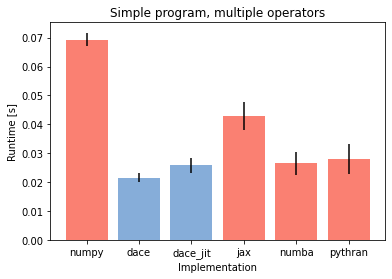

In [17]:
barplot('Simple program, multiple operators')

## Loops

Here we test how interpreter overhead can be mitigated by the Python compiling frameworks. Let's take another application from Numba's [5 minute guide](https://numba.readthedocs.io/en/stable/user/5minguide.html):

In [18]:
def go_fast(a):
    trace = 0.0
    for i in range(a.shape[0]):
        trace += np.tanh(a[i, i])
    return a + trace

In [19]:
import numpy as np
b = np.random.rand(1000, 1000)

TIMES = {}

In [20]:
TIMES['numpy'] = %timeit -o go_fast(b)

1.94 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
numba_fast = numba.jit(go_fast)

In [22]:
import jax.numpy as jnp

@jax.jit
def jax_fast(a):
    trace = 0.0
    for i in range(a.shape[0]):
        trace += jnp.tanh(a[i, i])
    return a + trace

In [23]:
N = dace.symbol('N')

@dace.program(auto_optimize=True)
def dace_fast(a: dace.float64[N, N]):
    trace = 0.0
    for i in range(N):
        trace += np.tanh(a[i, i])
    return a + trace

In [24]:
%%pythran
from numpy import tanh

#pythran export pythran_fast(float64[:,:])
def pythran_fast(a):
    trace = 0.0
    for i in range(a.shape[0]):
        trace += tanh(a[i, i])
    return a + trace

In [25]:
import time
start = time.time()
csdfg = dace_fast.compile(b)
print('DaCe compilation time:', time.time() - start, 'seconds')

DaCe compilation time: 0.5581727027893066 seconds


In [26]:
%timeit -r 1 -n 1 jax_fast(b).block_until_ready()
%timeit -r 1 -n 1 numba_fast(b)
%timeit -r 1 -n 1 pythran_fast(b)

11.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
147 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Note that the slow JAX first run time is due to the inspector/executor model, in which the compilation time depends on the size of the array.

In [27]:
TIMES['jax'] = %timeit -o jax_fast(b).block_until_ready()

2.28 ms ± 538 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
TIMES['numba'] = %timeit -o numba_fast(b)

970 µs ± 130 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [29]:
TIMES['pythran'] = %timeit -o pythran_fast(b)

673 µs ± 54.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [30]:
TIMES['dace'] = %timeit -o csdfg(b, N=b.shape[0])

668 µs ± 56.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


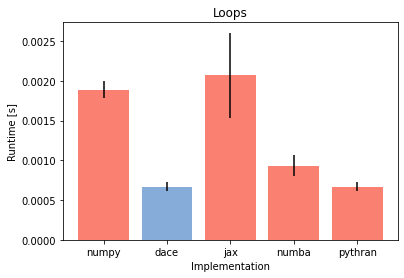

In [31]:
barplot('Loops')

### Varying sizes

Since the DaCe program was defined symbolically, the input array size can be changed without recompilation:

In [32]:
sizes = [np.random.randint(700, 5000) for _ in range(10)]
arrays = [np.random.rand(n, n) for n in sizes]

def vary_size(call):
    for a in arrays:
        call(a)

def vary_size_dace(call):
    for a, n in zip(arrays, sizes):
        call(a, N=n)
    
def vary_size_jax(call):
    for a in arrays:
        call(a).block_until_ready()
    
TIMES = {}

In [33]:
TIMES['numpy'] = %timeit -o vary_size(go_fast)
TIMES['numba'] = %timeit -o vary_size(numba_fast)
TIMES['pythran'] = %timeit -o vary_size(pythran_fast)
TIMES['dace'] = %timeit -o vary_size_dace(csdfg)
TIMES['jax'] = %timeit -o vary_size_jax(jax_fast)

155 ms ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
125 ms ± 3.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
124 ms ± 2.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
114 ms ± 8.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
334 ms ± 166 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


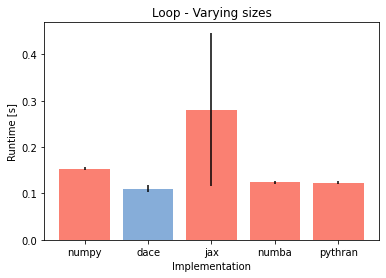

In [34]:
barplot('Loop - Varying sizes')

## Auto-parallelization

DaCe can use data-centric dependency analysis to not only track and reduce data movement, but also automatically extract parallel regions in code. Here we look at a simple program and how it is run in parallel. We use the `auto_optimize` flag in the `dace.program` decorator to automatically apply optimization heuristics.

In [35]:
def element_update(a):
    return a * 5

def someforloop(A):
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            A[i, j] = element_update(A[i, j])

In [36]:
a = np.random.rand(1000, 1000)
daceloop = dace.program(auto_optimize=True)(someforloop)

Here it is compared with numpy and numba's similar capability:

In [37]:
numbaloop = numba.jit(parallel=True)(someforloop)
csdfg = daceloop.compile(a)

TIMES = {}
TIMES['numpy'] = %timeit -o someforloop(a)
TIMES['numba'] = %timeit -o numbaloop(a)
TIMES['dace'] = %timeit -o csdfg(a)

446 ms ± 41.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<ipython-input-35-c42936c82690>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "someforloop" failed type inference due to: Untyped global name 'element_update': Cannot determine Numba type of <class 'function'>

File "<ipython-input-35-c42936c82690>", line 7:
def someforloop(A):
    <source elided>
        for j in range(A.shape[1]):
            A[i, j] = element_update(A[i, j])
            ^

  def someforloop(A):
<ipython-input-35-c42936c82690>:4: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "someforloop" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-35-c42936c82690>", line 5:
def someforloop(A):
    for i in range(A.shape[0]):
    ^

  def someforloop(A):
/home/user/anaconda3/envs/py38/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "someforloop" was c

406 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
549 µs ± 212 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


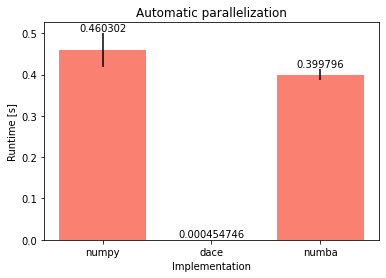

In [38]:
barplot('Automatic parallelization', labels=True)

As we can see, the nested call triggered the numba code to stay sequential, whereas the global data dependency analysis in DaCe allowed it to parallelize the code, yielding a performance of **549 µs** vs. 406 ms.

## 3D Heat Diffusion

As a more realistic application, the following program, `heat3d` is taken from the [NPBench numpy benchmark](https://github.com/spcl/npbench). It runs a three-dimensional stencil repeatedly to perform heat diffusion:

In [39]:
def heat3d(TSTEPS, A, B):
    for t in range(1, TSTEPS):
        B[1:-1, 1:-1,
          1:-1] = (0.125 * (A[2:, 1:-1, 1:-1] - 2.0 * A[1:-1, 1:-1, 1:-1] +
                            A[:-2, 1:-1, 1:-1]) + 0.125 *
                   (A[1:-1, 2:, 1:-1] - 2.0 * A[1:-1, 1:-1, 1:-1] +
                    A[1:-1, :-2, 1:-1]) + 0.125 *
                   (A[1:-1, 1:-1, 2:] - 2.0 * A[1:-1, 1:-1, 1:-1] +
                    A[1:-1, 1:-1, 0:-2]) + A[1:-1, 1:-1, 1:-1])
        A[1:-1, 1:-1,
          1:-1] = (0.125 * (B[2:, 1:-1, 1:-1] - 2.0 * B[1:-1, 1:-1, 1:-1] +
                            B[:-2, 1:-1, 1:-1]) + 0.125 *
                   (B[1:-1, 2:, 1:-1] - 2.0 * B[1:-1, 1:-1, 1:-1] +
                    B[1:-1, :-2, 1:-1]) + 0.125 *
                   (B[1:-1, 1:-1, 2:] - 2.0 * B[1:-1, 1:-1, 1:-1] +
                    B[1:-1, 1:-1, 0:-2]) + B[1:-1, 1:-1, 1:-1])

In [40]:
# Using the "L" size
TSTEPS, N = 100, 70
A = np.fromfunction(lambda i, j, k: (i + j + (N - k)) * 10 / N, (N, N, N),
                    dtype=np.float64)
B = np.copy(A)

In [41]:
dace_heat3d = dace.program(auto_optimize=True)(heat3d)
numba_heat3d = numba.jit(nopython=True, parallel=True)(heat3d)

In [42]:
%%pythran
#pythran export pythran_heat3d(int, float64[:,:,:], float64[:,:,:])
def pythran_heat3d(TSTEPS, A, B):
    for t in range(1, TSTEPS):
        B[1:-1, 1:-1,
          1:-1] = (0.125 * (A[2:, 1:-1, 1:-1] - 2.0 * A[1:-1, 1:-1, 1:-1] +
                            A[:-2, 1:-1, 1:-1]) + 0.125 *
                   (A[1:-1, 2:, 1:-1] - 2.0 * A[1:-1, 1:-1, 1:-1] +
                    A[1:-1, :-2, 1:-1]) + 0.125 *
                   (A[1:-1, 1:-1, 2:] - 2.0 * A[1:-1, 1:-1, 1:-1] +
                    A[1:-1, 1:-1, 0:-2]) + A[1:-1, 1:-1, 1:-1])
        A[1:-1, 1:-1,
          1:-1] = (0.125 * (B[2:, 1:-1, 1:-1] - 2.0 * B[1:-1, 1:-1, 1:-1] +
                            B[:-2, 1:-1, 1:-1]) + 0.125 *
                   (B[1:-1, 2:, 1:-1] - 2.0 * B[1:-1, 1:-1, 1:-1] +
                    B[1:-1, :-2, 1:-1]) + 0.125 *
                   (B[1:-1, 1:-1, 2:] - 2.0 * B[1:-1, 1:-1, 1:-1] +
                    B[1:-1, 1:-1, 0:-2]) + B[1:-1, 1:-1, 1:-1])

In [43]:
# Warmup
%timeit -r 1 -n 1 dace_heat3d(TSTEPS, A, B)
%timeit -r 1 -n 1 numba_heat3d(TSTEPS, A, B)
%timeit -r 1 -n 1 pythran_heat3d(TSTEPS, A, B)

3.28 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.75 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
216 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [44]:
TIMES = {}
TIMES['numpy'] = %timeit -o heat3d(TSTEPS, A, B)

799 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
TIMES['dace'] = %timeit -o dace_heat3d(TSTEPS, A, B)
TIMES['numba'] = %timeit -o numba_heat3d(TSTEPS, A, B)
TIMES['pythran'] = %timeit -o pythran_heat3d(TSTEPS, A, B)

11.2 ms ± 406 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
77.1 ms ± 3.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
184 ms ± 573 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


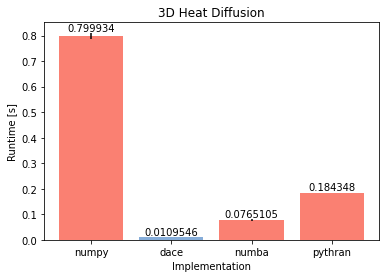

In [46]:
barplot('3D Heat Diffusion', labels=True)

## Benchmarking and Instrumentation API

When optimizing programs in DaCe, it is useful to know the raw time the compiled program takes or any of its components. For this purpose, DaCe includes an instrumentation API, which allows you to time each SDFG, state, map, or tasklet directly from the code.

The instrumentation providers given in DaCe can measure different metrics: wall-clock time, GPU (CUDA/HIP) events, PAPI performance counters, and more (it's extensible).

Performance results are saved as report files in CSV format or the `chrome://tracing` JSON format for easy timeline view.

### Profiling API
First, we demonstrate the profiling API, which is a simple low-level timer that will run every called DaCe program a number of times and print out the median runtime.

In [47]:
# Setup some optional dependencies for viewing results and printing progress
%pip install pandas tqdm

...


In [48]:
# Temporarily set the DACE_profiling config to True
with dace.config.set_temporary('profiling', value=True):
    # You can control the number of times a program is run with the treps configuration
    with dace.config.set_temporary('treps', value=100):
        daceloop(a)


Profiling...
Profiling: 100%|██████████| 100/100 [00:00<00:00, 1106.55it/s]
DaCe 0.2954999217763543 ms


This can also be controlled with environment variables. Setting `DACE_profiling=1` and `DACE_treps=100` achieves the same effect on the entire script.

The report is saved as a CSV file in the `.dacecache/<program>/profiling` folder, where `<program>` is the program or SDFG name.

In [49]:
import pandas as pd

df = pd.read_csv('.dacecache/someforloop/profiling/results-1644308750891.csv')
df.head(10)

,Program,Optimization,Problem_Size,Runtime_sec
0,someforloop_0,DaCe,-f,0.006098
1,someforloop_0,DaCe,-f,0.000454
2,someforloop_0,DaCe,-f,0.000398
3,someforloop_0,DaCe,-f,0.000367
4,someforloop_0,DaCe,-f,0.000271
5,someforloop_0,DaCe,-f,0.000304
6,someforloop_0,DaCe,-f,0.000249
7,someforloop_0,DaCe,-f,0.004182
8,someforloop_0,DaCe,-f,0.000413
9,someforloop_0,DaCe,-f,0.000379


### Instrumentation API

The Instrumentation API allows more fine-grained control over measuring program metrics. It creates a JSON report in `.dacecache/<program>/perf`, which can be obtained with the API or viewed with any Chrome Tracing capable viewer. More usage information and how to use the API to tune programs can be found in the [program tuning sample](https://github.com/spcl/dace/blob/master/samples/optimization/tuning.py).

In [50]:
@dace.program
def twomaps(A):
    B = np.sin(A)
    return B * 2.0

a = np.random.rand(1000, 1000)
sdfg = twomaps.to_sdfg(a)
sdfg

We will now instrument the each of the maps in the program separately, so see which one is a potential bottleneck:

In [51]:
# Get all maps
maps = [n for n, _ in sdfg.all_nodes_recursive() if isinstance(n, dace.nodes.MapEntry)]

# Instrument with wall-clock timer
for m in maps:
    m.instrument = dace.InstrumentationType.Timer

In [52]:
# Run SDFG and create report
sdfg(a)

array([[0.57072424, 1.62590182, 0.54045806, ..., 1.42865334, 0.74420338,
        1.34051505],
       [0.56169953, 0.33241204, 1.18265858, ..., 1.18433834, 0.45687267,
        0.03173654],
       [0.21026808, 1.38539332, 1.13363577, ..., 1.20282264, 1.26179853,
        0.94529241],
       ...,
       [0.58080043, 1.38410909, 1.12745291, ..., 1.54076988, 0.73878048,
        0.76149314],
       [1.34720999, 1.08957421, 0.75846927, ..., 1.01317063, 0.13351551,
        1.13468273],
       [1.2947957 , 1.0325859 , 1.50298925, ..., 0.56601298, 1.08368357,
        1.29880744]])

In [53]:
# Get the latest instrumentation report from .dacecache/twomaps/perf
report = sdfg.get_latest_report()

# Print report in a nicely readable format
print(report)

Instrumentation report
SDFG Hash: 0f02b642249b861dc94b7cbc729190d4b27cab79607b8f28c7de3946e62d5977
---------------------------------------------------------------------------
Element        Runtime (ms)   
               Min            Mean           Median         Max            
---------------------------------------------------------------------------
SDFG (0)                                                                   
|-State (0)                                                                
| |-Node (0)                                                               
| | |Map _numpy_sin__map:                                                            
| | |          11.654         11.654         11.654         11.654         
| |-Node (5)                                                               
| | |Map _Mult__map:                                                            
| | |          1.524          1.524          1.524          1.524          
-------------------

As we can see, the `np.sin` statement is more expensive than the multiplication statement.

These reports can also be loaded directly to the Visual Studio code plugin to overlay the information on the graph, as shown below:

![](https://raw.githubusercontent.com/spcl/dace-vscode/master/images/analysis.gif)